# (Gradient Based) Optimization for Machine Learning

We will cover how to use the python package **autograd** to solve simple optimization problems. 

Autograd is a lightweight package that automates differentiating through numpy code. Understanding how to use it (and how it works) is not only a useful skill in itself, but also will it help you understand the inner workings of popular deep learning packages such as PyTorch. 

(optional) Check out the github page of autograd: https://github.com/HIPS/autograd. Specifically, check out the "examples" directory, where you can find transparent implementations of many interesting machine learning methods. 

In [26]:
import autograd.numpy as np
import autograd
# bonus exercise: try using jax instead of autograd
# import jax as jnp
import numpy as onp
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)
import time
np.random.seed(1)

This tutorial explores _optimization for machine learning_.

We will implement a function and then use gradient-based optimization to find it's minimum value. 
For ease of visualization we will consider scalar functions of 2-d vectors. 
In other words $f: \mathbb{R}^2 \rightarrow \mathbb{R}$

One example of such a function is the simple quadratic $$f(x) = \frac{1}{2} x^T x = \frac{1}{2}(x_0^2 + x_1^2)$$ where $x_i$ represents the $i$-th entry of the vector $x$.

**Question: is this function convex?**

Let's implement this in code and print $f(x)$ for a few random $x$

In [7]:
def f(x):
    return 0.5*np.dot(x.T, x)

for _ in range(5):  
    x = np.random.randn(2)  # random 2-d vector
    print('x={}, f(x)={:.3f}'.format(x, f(x)))

x=[-1.101  1.145], f(x)=1.261
x=[0.902 0.502], f(x)=0.533
x=[ 0.901 -0.684], f(x)=0.640
x=[-0.123 -0.936], f(x)=0.445
x=[-0.268  0.53 ], f(x)=0.177


This simple function has minimum value $f(x^*)=0$ given by $x^* = [0, 0]^T$. 

Let's look at the more general quadratic 
$$f(x) = \frac{1}{2}x^T A x$$
where $A \in \mathbb{R}^{2 \times 2}$ is a positive semi-definite matrix. (Intuitively, these are matrices that "stretch or shrink [eigenvectors] without rotating them. ")

Notice that we get the previous function when we set $A$ to the identity matrix $I$.

We can think of this function as a quadratic bowl whose curvature is specified by the value of $A$.
This is evident in the isocontour plots of $f(x)$ for various $A$.
Let's take a look.


In [22]:
# helper function yielding a random positive semi-definite matrix
def random_psd_matrix(seed=None):
    """return random positive semi-definite matrix with norm one"""
    np.random.seed(seed)
    A = np.random.randn(2,2)
    A = np.dot(A.T,A)
    A = np.dot(A.T,A)
    A = A / np.linalg.norm(A, ord=2)
    return A

# define forward function
def f(x, a):
    """f(x) = x^T A x"""
    y = 0.5*np.dot(x.T, np.dot(a, x))
    return y

# helper function for isocontour plotting
def plot_isocontours(one_d_grid, g):
    """
    first makes a 2d grid from the 1d grid
    then plots isocontours using the function g
    """
    X,Y = np.meshgrid(one_d_grid, one_d_grid)  # build 2d grid
    Z = np.zeros_like(X)
    # numpy bonus exercise: can you think of a way to vectorize the following for-loop?
    for i in range(len(X)):
        for j in range(len(X.T)):
            Z[i, j] = g(np.array((X[i, j], Y[i, j])))  # compute function values
    fig, ax = plt.subplots()
    ax.contour(X, Y, Z, 100)
    return fig, ax 

A=[[1. 1.]
 [1. 1.]]


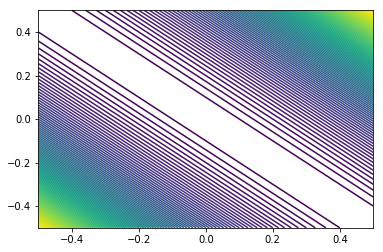

A=[[0.435 0.467]
 [0.467 0.614]]


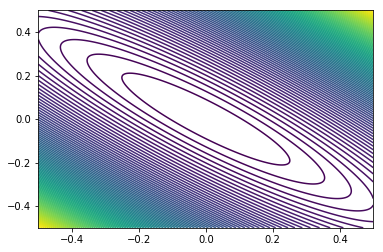

A=[[ 0.942 -0.206]
 [-0.206  0.272]]


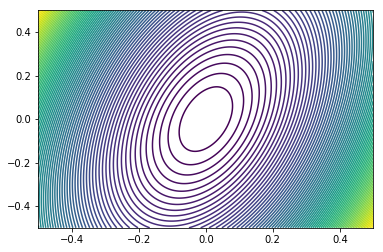

In [23]:
for A in [np.ones((2, 2)), random_psd_matrix(0), random_psd_matrix(1)]:  # try a few values of A
    print('A={}'.format(A))
    fig, ax = plot_isocontours(np.linspace(-0.5, 0.5, 400), lambda x: f(x, A))
    plt.show()
    time.sleep(1.0)

Now let's learn how to find the minimal value of $f(x)$. 
We need to solve the following optimization problem:
$$x^* = \underset{x}{\arg \min} \quad \frac{1}{2}x^T A x = \underset{x}{\arg \min} \quad f(x)$$


Modern machine learning optimization tools rely on gradients. 
Consider gradient descent, which initializes $x_0$ at random then follows the update rule 
$$ x_{t+1} \leftarrow x_t - \eta \nabla_x f(x_t)$$
where $\eta$ represents the learning rate.

So we need to compute $\nabla_x f(x)$. For simple functions like ours, we can compute this analytically:
$$\nabla_x f(x) = \nabla_x \left( \frac{1}{2}x^T A x \right) = A x$$

In other words, to compute the gradient of $f(x)$ at a particular $x=x'$, we matrix multiply $A$ with $x'$

But deriving the analytic gradients by hand becomes painful as $f$ gets more complicated. Instead we can use automatic differentation packages like [`autograd`](https://github.com/HIPS/autograd) or [`Jax`](https://github.com/google/jax) to do this hard work for us. All we need to do is specify the forward function.

Let's take a look at the two approaches:

In [24]:
# define df/dx via automatic differentiation
df_dx = autograd.grad(f, 0)
# ^ the second argument of grad specifies which argument we're differentiating with respect to (i.e. x, 
# or A in this case). Note that f(x, A) has 2 arguments: x, A. So does grad{f(x,A)}, also x and A. 

# define df/dx analytically 
def analytic_gradient(x, A):
    return np.dot(A, x)

for A in [np.zeros((2, 2)), np.eye(2), random_psd_matrix()]:  # try a few values of A
    x = np.random.randn(2)  # generate x randomly
    print('')
    print('x={}\nA={}\nf(x,A)={:.3f}\ndf/dx={}'.format(x, A, f(x,A), df_dx(x,A)))
    assert np.isclose(np.sum((df_dx(x, A) - analytic_gradient(x, A)))**2, 0.), 'bad maths'  # unit test
    


x=[1.848 0.821]
A=[[0. 0.]
 [0. 0.]]
f(x,A)=0.000
df/dx=[0. 0.]

x=[-0.322 -0.562]
A=[[1. 0.]
 [0. 1.]]
f(x,A)=0.210
df/dx=[-0.322 -0.562]

x=[-0.809 -0.587]
A=[[ 0.588 -0.489]
 [-0.489  0.421]]
f(x,A)=0.033
df/dx=[-0.189  0.148]


Now that we know how to compute $\nabla_x f(x)$ using `autograd`, let's implement gradient descent.

To make the implementation of GD crystal clear, let's break this update expression from above into two lines:
$$ \delta_{t+1} \leftarrow - \eta \nabla_x f(x_t)$$
$$ x_{t+1} \leftarrow x_t + \delta_{t+1}$$

This yields the following `autograd` implementation:

In [40]:
A = random_psd_matrix(0)  # argument specifies the random seed


# hyperparameters
eigs, _ = onp.linalg.eig(A)
condition = eigs[-1] / eigs[0] 
print("Eigenvalues of A = {}".format(eigs))
print("Optimal Convergence rate = {}".format((condition - 1)/(condition + 1)))
print("Max_learning rate = {}".format(2.0 / eigs[-1]))
print("Optimal learning rate = {}".format(2.0 / (eigs[0] + eigs[1])))
# See https://distill.pub/2017/momentum/ for more details on this if interested

Eigenvalues of A = [0.049 1.   ]
Optimal Convergence rate = 0.906960413187
Max_learning rate = 2.0


final value f(x)=0.144 at x=[0.521 0.264]
final value f(x)=0.002 at x=[ 0.227 -0.154]
final value f(x)=0.035 at x=[ 0.921 -0.761]


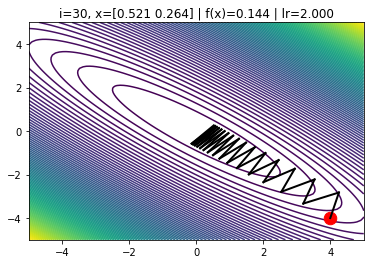

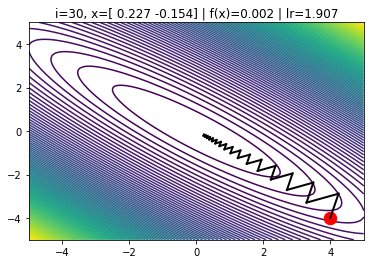

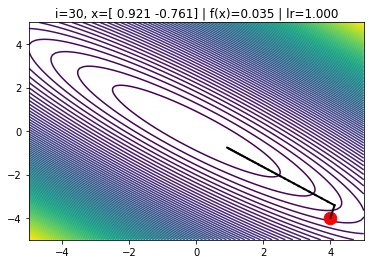

In [43]:
# First learning rate too big, second one optimal, third one too small
for LEARNING_RATE in [2.0, 2.0 / (eigs[0] + eigs[1]), 1.0]:
  fig, ax = plot_isocontours(np.linspace(-5, 5, 100), lambda x: f(x, A))  # plot function isocontours

  INITIAL_VAL = np.array([4., -4.])  # initialize

  x = np.copy(INITIAL_VAL)
  ax.plot(*x, marker='.', color='r', ms=25)  # plot initial values



  from IPython import display

  for i in range(31):
  #     input("Press Enter to continue...")  # optional; Enter key triggers next update
  #     time.sleep(0.5)  # optional; slow down animation if the flickering is distracting

      x_old = np.copy(x)
      
      delta = -LEARNING_RATE*df_dx(x, A)  # compute gradient times learning rate
      x += delta  # update params
      
      # plot
      ax.plot([x_old[0], x[0]], [x_old[1], x[1]], linestyle='-', color='k',lw=2)  # plot a line connecting old and new param values
      
  fig.canvas.draw()
  ax.set_title('i={}, x={} | f(x)={:.3f} | lr={:.3f}'.format(i, x, f(x, A), LEARNING_RATE))
  #display.display(fig)
  #display.clear_output(wait=True)

  print('final value f(x)={:.3f} at x={}'.format(f(x, A), x))


Cool! Now let's try gradient descent _with momentum_. The hyperparameters are the learning rate $\eta$ and momentum value $\alpha \in [0, 1)$.

We randomly initialize $x_0$ like before. We initialize $\delta_0$ to the zero vector. Then proceed with updates as:
$$\delta_{t+1} \leftarrow -\eta \nabla_x f(x) + \alpha \delta_t$$
$$x_{t+1} \leftarrow x_t + \delta_{t+1}$$

This yields the following `autograd` implementation:

In [118]:
A = random_psd_matrix(0)  # 0, 1, 3
eigs, _ = onp.linalg.eig(A)
eigs.sort()
condition = eigs[-1] / eigs[0]
print("Eigenvalues of A = {}".format(eigs))
print("Optimal Convergence rate = {:.3f}".format((onp.sqrt(condition) - 1)/(onp.sqrt(condition) + 1)))
opt_lr = ((2.0 / (onp.sqrt(eigs[-1]) + onp.sqrt(eigs[0])))**2)
opt_alpha = (((onp.sqrt(eigs[-1]) - onp.sqrt(eigs[0])) / (onp.sqrt(eigs[-1]) + onp.sqrt(eigs[0]))) ** 2)
print("Optimal (learning rate = {:.3f}, momentum coefficient = {:.3f})".format(opt_lr, opt_alpha))
max_lr = (2.0 + 2.0*opt_alpha) / eigs[-1]
print("Max_learning rate with optimal momentum coefficient = {:.3f}".format(max_lr))

Eigenvalues of A = [0.049 1.   ]
Optimal Convergence rate = 0.638
Optimal (learning rate = 2.684, momentum coefficient = 0.407)
Max_learning rate with optimal momentum coefficient = 2.814


final value f(x)=0.00017651 at x=[ 0.043 -0.015]
final value f(x)=0.80690650 at x=[0.828 0.964]
final value f(x)=0.43839557 at x=[ 3.257 -2.713]
final value f(x)=0.00000506 at x=[-0.01   0.006]


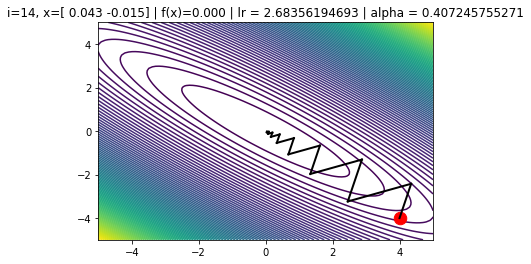

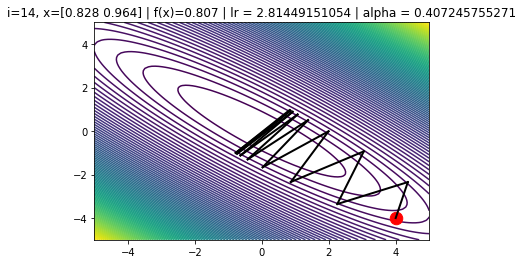

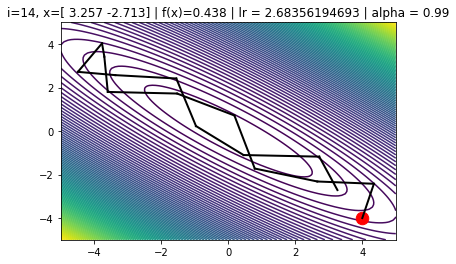

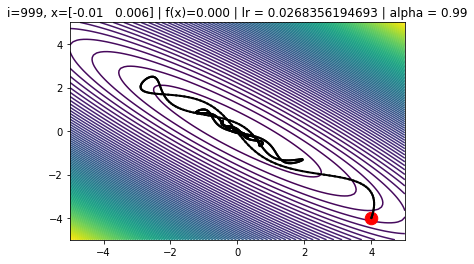

In [119]:
# hyperparameters
for LEARNING_RATE, ALPHA, num_iter in [(opt_lr, opt_alpha, 15), (max_lr, opt_alpha, 15), (opt_lr, .99, 15),  (opt_lr * 0.01, .99, 1000), ]:
  fig, ax = plot_isocontours(np.linspace(-5, 5, 100), lambda x: f(x, A))  # plot function isocontours

  # initialize
  x = np.copy(INITIAL_VAL)
  delta = np.zeros(2) 
  ax.plot(*x, marker='.', color='r', ms=25)  # plot initial values
  from IPython import display

  for i in range(num_iter):
  #    input("Press Enter to continue...")  # optional; Enter key triggers next update
  #    time.sleep(0.5)  # optional; slow down animation if the flickering is distracting

      x_old = np.copy(x)
      delta_old = np.copy(delta)
      
      g = df_dx(x, A)  # compute standard gradient
      delta = g + ALPHA*delta_old  # update momentum term
      x += -LEARNING_RATE*delta  # update params
      
      # plot
      ax.plot([x_old[0], x[0]], [x_old[1], x[1]],'-k',lw=2)  # plot a line connecting old and new param values
  fig.canvas.draw()
  ax.set_title('i={}, x={} | f(x)={:.3f} | lr = {} | alpha = {}'.format(i, x, f(x, A), LEARNING_RATE, ALPHA))
  #display.display(fig)
  #display.clear_output(wait=True)

  print('final value f(x)={:.8f} at x={}'.format(f(x, A), x))


(optional) Distill (https://distill.pub) is an amazing resource to both learn concepts about machine learning, but also a new format for serious scientific discourse. If you are interested in learning more about why momentum is very effective, check this out: https://distill.pub/2017/momentum/ 

Nice! Now try implementing gradient-based optimization yourself in the worksheet part of the tutorial.